<h1>Face Recognition using FaceNet</h1>
Based on <a href="https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/">this tutorial</a>.

<h3>Imports</h3>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
from mtcnn.mtcnn import MTCNN
from os import listdir
from matplotlib import pyplot
%matplotlib inline
from os.path import isdir
from numpy import savez_compressed, load, expand_dims, asarray, savez_compressed
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.svm import SVC
from random import choice
import numpy as np
print("TF version:", tf.__version__)

Using TensorFlow backend.


TF version: 2.2.0


<h3>Main dataset path</h3>

In [2]:
main_path = "facerecognition"
#dataset_name = "5-celebrity-faces-dataset"
dataset_name = "celebrity-faces-extended"

<h2>Load Keras FaceNet model</h2>
Pre-trained model can be downloaded <a href="https://drive.google.com/drive/folders/1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn">here</a>.

In [3]:
# example of loading the keras facenet model

# load the model
fnmodel = load_model(main_path + "/facenet_keras.h5")
print("Loaded facenet_keras model")
# summarize input and output shape
print("Input shape:")
print("\t", fnmodel.inputs)
print("Output shape:")
print("\t", fnmodel.outputs)

Loaded facenet_keras model
Input shape:
	 [<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
Output shape:
	 [<tf.Tensor 'Bottleneck_BatchNorm/Identity:0' shape=(None, 128) dtype=float32>]


<h2>Load and detect a face in a picture using MTCNN</h2>

In [4]:
# function for face detection with mtcnn

# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert("RGB")
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]["box"]
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

<h2>Extracting faces from the dataset</h2>
5 Celebrity faces  dataset can be downloaded from <a href="https://www.kaggle.com/dansbecker/5-celebrity-faces-dataset">Kaggle</a>.

<h2>Prepare dataset for use with FaceNet</h2>

In [5]:
# load images and extract faces for all images in a directory
def load_faces(directory):
    faces = list()
    # enumerate files
    for filename in listdir(directory):
        # path
        path = directory + filename
        # get face
        face = extract_face(path)
        # store
        faces.append(face)
    return faces


# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X, y = list(), list()
    # enumerate folders, on per class
    for subdir in listdir(directory):
        # path
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not isdir(path):
            continue
        # load all faces in the subdirectory
        faces = load_faces(path)
        # create labels
        labels = [subdir for _ in range(len(faces))]
        # summarize progress
        print("\t%d examples of %s" % (len(faces), subdir))
        # store
        X.extend(faces)
        y.extend(labels)
    return asarray(X), asarray(y)


# load train dataset
print("Load training dataset:")
trainX, trainy = load_dataset(main_path + "/" + dataset_name + "/train/")
# load test dataset
print("Load test dataset:")
testX, testy = load_dataset(main_path + "/" + dataset_name + "/val/")
# save arrays to one file in compressed format
savez_compressed(main_path + "/" + dataset_name + ".npz", trainX, trainy, testX, testy)
print("Images compressed to file")

Load training dataset:
	12 examples of pippi_langstrump
	14 examples of ben_afflek
	10 examples of stellan_skarsgard
	19 examples of liam_neeson
	16 examples of alicia_vikander
	19 examples of madonna
	16 examples of christian_bale
	17 examples of elton_john
	22 examples of mindy_kaling
	14 examples of george_clooney
	21 examples of jerry_seinfeld
	17 examples of miley_cyrus
Load test dataset:
	5 examples of pippi_langstrump
	5 examples of ben_afflek
	5 examples of stellan_skarsgard
	5 examples of liam_neeson
	5 examples of alicia_vikander
	5 examples of madonna
	5 examples of christian_bale
	5 examples of elton_john
	5 examples of mindy_kaling
	5 examples of george_clooney
	5 examples of jerry_seinfeld
	5 examples of miley_cyrus
Images compressed to file


<h2>Create Face Embeddings</h2>
Creates and stores FaceNet Face Embeddings for all images.

In [6]:
# get the face embedding for one face
def get_embedding(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype("float32")
    # standardize pixel values across channels (global)
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = expand_dims(face_pixels, axis=0)
    # make prediction to get embedding
    yhat = model.predict(samples)
    return yhat[0]

In [7]:
# calculate a face embedding for each face in the dataset using facenet
# load the face dataset
data = load(main_path + "/" + dataset_name + ".npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded dataset:")
print("\t{0} training images of size {1}x{2}x{3}".format(trainX.shape[0], trainX.shape[1], trainX.shape[2], trainX.shape[3]))
print("\t{0} test images of size {1}x{2}x{3}".format(testX.shape[0], testX.shape[1], testX.shape[2], testX.shape[3]))
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(fnmodel, face_pixels)
    newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print("Created embeddings of size {0} for {1} training images".format(newTrainX.shape[1],newTrainX.shape[0]))
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(fnmodel, face_pixels)
    newTestX.append(embedding)
newTestX = asarray(newTestX)
print("Created embeddings of size {0} for {1} test images".format(newTestX.shape[1],newTestX.shape[0]))
# save arrays to one file in compressed format
savez_compressed(main_path + "/" + dataset_name + "-embeddings.npz", newTrainX, trainy, newTestX, testy)
print("Embeddings compressed to file")

Loaded dataset:
	197 training images of size 160x160x3
	60 test images of size 160x160x3
Created embeddings of size 128 for 197 training images
Created embeddings of size 128 for 60 test images
Embeddings compressed to file


<h2>Face Recognition SVM</h2>
Train a Linear SVM classifier on the Face Embeddings.

In [8]:
# load dataset
data = load(main_path + "/" + dataset_name + "-embeddings.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
# normalize input vectors
in_encoder = Normalizer(norm="l2")
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel="linear", probability=True)
model.fit(trainX, trainy)
print("Trained Linear SVM model on embeddings")
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print("Training accuracy: {0:.2f}%".format(score_train*100))
print("Test accuracy: {0:.2f}%".format(score_test*100))

Trained Linear SVM model on embeddings
Training accuracy: 100.00%
Test accuracy: 100.00%


<h2>Test model on a random face in test dataset</h2>

In [9]:
def find(y, classval):
    st = -1
    en = -1
    for i in range(0,len(y)):
        if y[i] == classval:
            st = i
            break
    for i in range(len(y)-1,0,-1):
        if y[i] == classval:
            en = i
            break
    return st,en


def find_persons(y):
    cvals = np.unique(y)
    for i in range(0,len(cvals)):
        name = out_encoder.inverse_transform([cvals[i]])
        st,en = find(y, cvals[i])
        print("\t{0}-{1}\t {2}".format(st,en,name[0]))


# Index ranges for the different persons
print("Persons:", len(out_encoder.classes_))
print("Training images:", len(trainX))
print("Test images:", len(testX))

print("\nImage indices (training dataset):")
find_persons(trainy)
print("\nImage indices (test dataset):")
find_persons(testy)

Persons: 12
Training images: 197
Test images: 60

Image indices (training dataset):
	55-70	 alicia_vikander
	12-25	 ben_afflek
	90-105	 christian_bale
	106-122	 elton_john
	145-158	 george_clooney
	159-179	 jerry_seinfeld
	36-54	 liam_neeson
	71-89	 madonna
	180-196	 miley_cyrus
	123-144	 mindy_kaling
	0-11	 pippi_langstrump
	26-35	 stellan_skarsgard

Image indices (test dataset):
	20-24	 alicia_vikander
	5-9	 ben_afflek
	30-34	 christian_bale
	35-39	 elton_john
	45-49	 george_clooney
	50-54	 jerry_seinfeld
	15-19	 liam_neeson
	25-29	 madonna
	55-59	 miley_cyrus
	40-44	 mindy_kaling
	0-4	 pippi_langstrump
	10-14	 stellan_skarsgard


Predicted:	christian_bale (60.78%)
Expected:	christian_bale

Class probabilities:
	4.37%	alicia_vikander
	3.36%	ben_afflek
	60.78%	christian_bale
	4.62%	elton_john
	8.48%	george_clooney
	2.45%	jerry_seinfeld
	2.46%	liam_neeson
	5.65%	madonna
	1.34%	miley_cyrus
	3.63%	mindy_kaling
	1.65%	pippi_langstrump
	1.20%	stellan_skarsgard


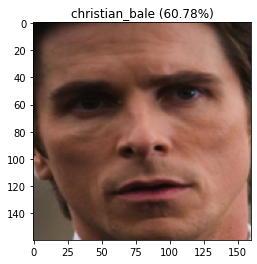

In [10]:
# load original faces
data = load(main_path + "/" + dataset_name + ".npz")

def predict_test_image(i):
    testX_faces = data["arr_2"]
    # test model on an example from the test dataset
    face_pixels = testX_faces[i]
    face_emb = testX[i]
    face_class = testy[i]
    face_name = out_encoder.inverse_transform([face_class])
    # prediction for the face
    samples = expand_dims(face_emb, axis=0)
    yhat_class = model.predict(samples)
    yhat_prob = model.predict_proba(samples)
    # get name
    class_index = yhat_class[0]
    class_probability = yhat_prob[0,class_index]*100
    predict_names = out_encoder.inverse_transform(yhat_class)
    # print result
    print("Predicted:\t{0} ({1:.2f}%)".format(predict_names[0], class_probability))
    print("Expected:\t%s" % face_name[0])
    # print probability for all classes
    print("\nClass probabilities:")
    cp = yhat_prob[0]
    for i in range(0, len(cp)):
        n = out_encoder.inverse_transform([i])
        p = cp[i]*100
        print("\t{0:.2f}%\t{1}".format(p,n[0]))
    # plot face
    pyplot.imshow(face_pixels)
    title = "{0} ({1:.2f}%)".format(predict_names[0], class_probability)
    pyplot.title(title)
    pyplot.show()

rnd_i = choice([i for i in range(testX.shape[0])])
predict_test_image(34)

<h2>Evaluates the train and test datasets and shows possible errors</h2>

In [11]:
def test_dataset(X_faces, X, y):
    errs = 0
    for selection in range(0, len(X_faces)):
        face_pixels = X_faces[selection]
        face_emb = X[selection]
        face_class = y[selection]
        face_name = out_encoder.inverse_transform([face_class])
        # prediction for the face
        samples = expand_dims(face_emb, axis=0)
        yhat_class = model.predict(samples)
        yhat_prob = model.predict_proba(samples)
        # get name
        class_index = yhat_class[0]
        class_probability = yhat_prob[0,class_index] * 100
        predict_names = out_encoder.inverse_transform(yhat_class)

        if (face_class != yhat_class):
            print("Predicted:\t{0} ({1:.2f}%)".format(predict_names[0], class_probability))
            print("Expected:\t%s" % face_name[0])
            # plot for fun
            pyplot.imshow(face_pixels)
            title = "{0} ({1:.2f}%)".format(predict_names[0], class_probability)
            pyplot.title(title)
            pyplot.show()
            errs += 1
        return errs
            

# load original faces
data = load(main_path + "/" + dataset_name + ".npz")
trainX_faces = data["arr_0"]
testX_faces = data["arr_2"]

e = test_dataset(trainX_faces, trainX, trainy)
print("Errors on training dataset:", e)

e = test_dataset(testX_faces, testX, testy)
print("Errors on test dataset:", e)

Errors on training dataset: 0
Errors on test dataset: 0


Predicted:	christian_bale (60.78%)

Class probabilities:
	4.37%	alicia_vikander
	3.36%	ben_afflek
	60.78%	christian_bale
	4.62%	elton_john
	8.48%	george_clooney
	2.45%	jerry_seinfeld
	2.46%	liam_neeson
	5.65%	madonna
	1.34%	miley_cyrus
	3.63%	mindy_kaling
	1.65%	pippi_langstrump
	1.20%	stellan_skarsgard


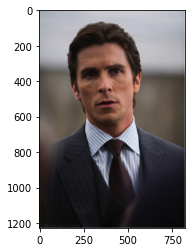

In [12]:
# Classifies an image
def classify_image(filename):
    face = extract_face(filename)
    face_arr = asarray(face)
    face_emb = get_embedding(fnmodel, face_arr)

    # normalize input vector
    in_encoder = Normalizer(norm="l2")
    x = in_encoder.transform([face_emb])

    # prediction for the face
    samples = expand_dims(x[0], axis=0)
    yhat_class = model.predict(samples)
    yhat_prob = model.predict_proba(samples)
    # get name
    class_index = yhat_class[0]
    class_probability = yhat_prob[0,class_index]*100
    predict_names = out_encoder.inverse_transform(yhat_class)
    # print result
    print("Predicted:\t{0} ({1:.2f}%)".format(predict_names[0], class_probability))

    # print probability for all classes
    print("\nClass probabilities:")
    cp = yhat_prob[0]
    for i in range(0, len(cp)):
        n = out_encoder.inverse_transform([i])
        p = cp[i]*100
        print("\t{0:.2f}%\t{1}".format(p,n[0]))

    image = Image.open(filename)
    pyplot.imshow(image)
    pyplot.show()


filename = main_path + "/" + dataset_name + "/val/christian_bale/T5.jpg"
classify_image(filename)